# CIFAR Code Along with CNN

The CIFAR-10 dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three
channels (RGB).
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image
may fall under:
    
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

As with the previous code along, make sure to watch the theory lectures! You'll want to be comfortable with:

* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Load the CIFAR-10 dataset

PyTorch makes the CIFAR-10 train and test datasets available through torchvision. The first time they're
called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision
will always look for a local copy before attempting another download.
The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and DataLoader.

In [4]:
transform = transforms.ToTensor()

In [6]:
train_data = datasets.CIFAR10(root='...../data_cnn', train=True,
                             download=True,
                              transform=transform)


Extracting ...../data_cnn/cifar-10-python.tar.gz to ...../data_cnn


In [7]:
test_data = datasets.CIFAR10(root='...../data_cnn', train=False,
                             download=True,
                              transform=transform)

Files already downloaded and verified


In [8]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ...../data_cnn
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ...../data_cnn
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create Loaders

In [10]:
torch.manual_seed(101)
train_loader=DataLoader(train_data, batch_size=10,shuffle=True)
test_loader=DataLoader(test_data, batch_size=10,shuffle=False)

### Define strings for labels

We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird',
'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that
our reports line up later.

In [11]:
class_names = ['plane', ' car', ' bird', ' cat', ' deer', ' dog', ' frog', 'horse', 'ship', 'truck']

We don't want to use the variable name "class" here, as it would overwrite Python's built-in keyword.

### View a batch of images

In [13]:
for images, labels in train_loader:
    break

Labels: [9 5 2 3 0 5 9 5 1 6]
Class: truck  dog  bird  cat plane  dog truck  dog  car  frog


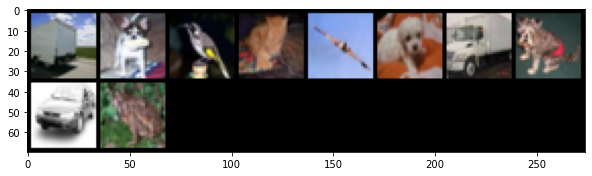

In [14]:
# Print the labels
print('Labels:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, row=5)# the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))
plt.show()

### Define the model

In the previous section we used two convolutional layers and two pooling layers before feeding data through a
fully connected hidden layer to our output. The model follows
CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. We'll use the same format here.

The only changes are:

* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3
filter), and a stride length of 1 pixel.
These are passed in as nn.Conv2d(3,6,3,1)

In [17]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)# 1st convolutional layer
        self.conv2= nn.Conv2d(6,16,3,1)# 2nd convolutional layer
        self.fc1 = nn.Linear(6*6*16, 120)# 1st fully connected layer
        self.fc2 =nn.Linear(120,84)# 2nd fully connected layer
        self.fc3 = nn.Linear(84,10)
        
        # Forward link
    def forward(self, x):
        x= F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)
        x= F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=x.view(-1,6*6*16)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return F.log_softmax(x,dim=1)
        
        
        

### Setting up our network

In [18]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Setting up parameters

In [22]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


### Define loss function & optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Train the model

This time we'll feed the data directly into the model without flattening it first.

In [24]:
import time
start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{10*b:6}/50000] loss: {loss.item():10.8f} \accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            # Apply the model
            y_val = model(X_test)
            
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0 batch: 1000 [ 10000/50000] loss: 2.23258233 ccuracy:  24.390%
epoch:  0 batch: 2000 [ 20000/50000] loss: 1.76381457 ccuracy:  31.105%
epoch:  0 batch: 3000 [ 30000/50000] loss: 1.00408840 ccuracy:  34.700%
epoch:  0 batch: 4000 [ 40000/50000] loss: 1.24737477 ccuracy:  37.165%
epoch:  0 batch: 5000 [ 50000/50000] loss: 1.66095698 ccuracy:  38.802%
epoch:  1 batch: 1000 [ 10000/50000] loss: 1.35545206 ccuracy:  47.170%
epoch:  1 batch: 2000 [ 20000/50000] loss: 1.33859098 ccuracy:  48.580%
epoch:  1 batch: 3000 [ 30000/50000] loss: 1.48402190 ccuracy:  49.303%
epoch:  1 batch: 4000 [ 40000/50000] loss: 1.71372283 ccuracy:  50.210%
epoch:  1 batch: 5000 [ 50000/50000] loss: 1.32072401 ccuracy:  50.698%
epoch:  2 batch: 1000 [ 10000/50000] loss: 1.54333222 ccuracy:  55.850%
epoch:  2 batch: 2000 [ 20000/50000] loss: 1.40108073 ccuracy:  55.775%
epoch:  2 batch: 3000 [ 30000/50000] loss: 1.10505891 ccuracy:  55.520%
epoch:  2 batch: 4000 [ 40000/50000] loss: 1.087273

### Optional: Save the model

This will save your trained model, without overwriting the saved model we have provided called CIFAR10-CNNModel-master.pt

In [25]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

### Plot the loss and accuracy comparisons

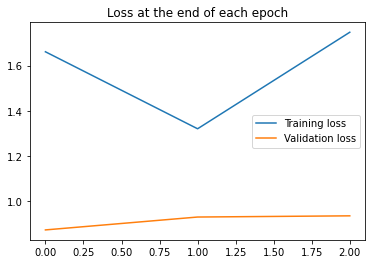

In [26]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

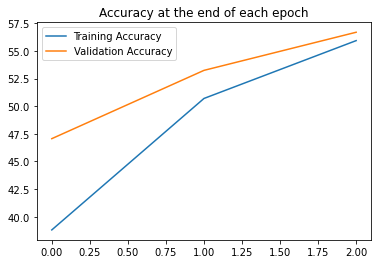

In [28]:
plt.plot([t/500 for t in train_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in test_correct], label = 'Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show()

### Evaluate Test Data

In [29]:
print(test_correct)
print()
print(f'Test Accuracy: {test_correct[-1].item()*100/10000:.3f}%')# print the most recent result as a percent

[tensor(4706), tensor(5324), tensor(5669)]

Test Accuracy: 56.690%


This is not as impressive as with MNIST, which makes sense. We would have to adjust our parameters to obtain
better results.
Still, it's much better than the 10% we'd get with random chance!

### Display the confusion matrix

In order to map predictions against ground truth, we need to run the entire test set through the model.
Also, since our model was not as accurate as with MNIST, we'll use a heatmap to better display the results.

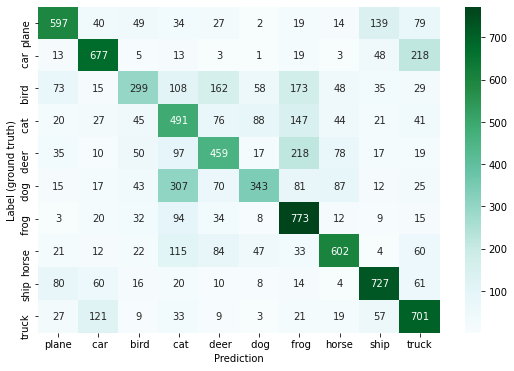

In [34]:
# Create a loader for the entire test set
import seaborn as sn
test_load_all = DataLoader(test_data, batch_size=10000, shuffle = False)

with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_all:
        y_val =model(x_test)
        predicted=torch.max(y_val,1)[1]
        correct+=(predicted ==y_test).sum()
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize =(9,6))
sn.heatmap(df_cm, annot=True, fmt ='d', cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel('Label (ground truth)')
plt.show();

### Examine the misses

We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll
do this in batches to save screen space.

In [37]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i]!=y_test[i]:
        misses = np.append(misses,i).astype('int64')

In [39]:
# Set up an iterator to feed batched rows
r = 8 # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.
Use Ctrl+Enter to remain on the cell between runs. You'll see a StopIteration once all the misses have been
seen.

In [40]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()

print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Index: [   10    12    15    17    21    22    24    25]
Label: [    0     5     8     7     0     4     5     2]
Class:  plane  dog ship horse plane  deer  dog  bird

Guess: [    4     4     6     3     2     0     4     4]
Class:   deer  deer  frog  cat  bird plane  deer  deer


IndexError: index out of range in self